# Overfitting and Regularization

## Imports

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [37]:
set_config(display='diagram')

## Settings

In [38]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [39]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

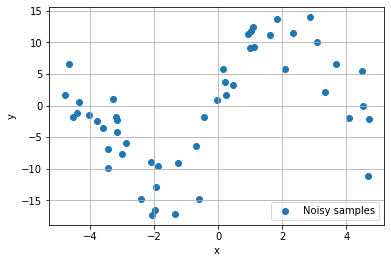

In [40]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

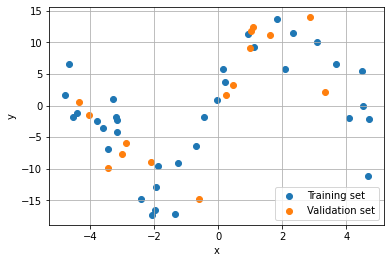

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [42]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [43]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [44]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

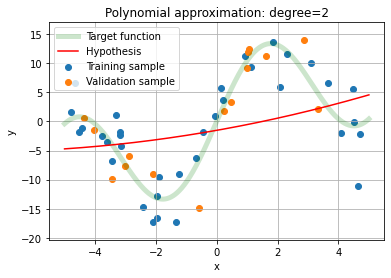

In [45]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

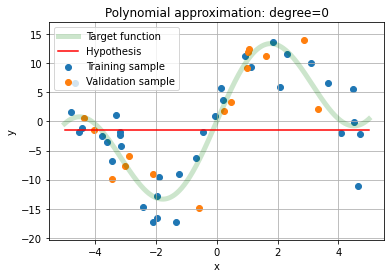

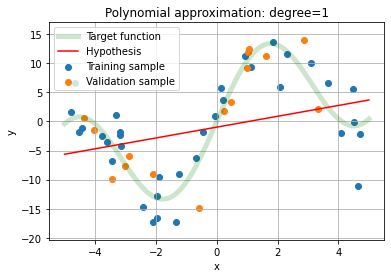

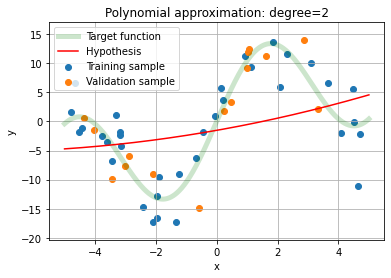

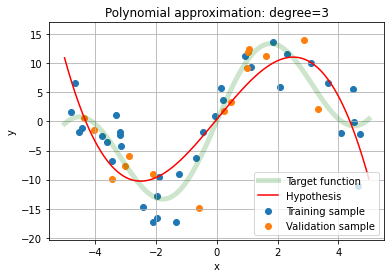

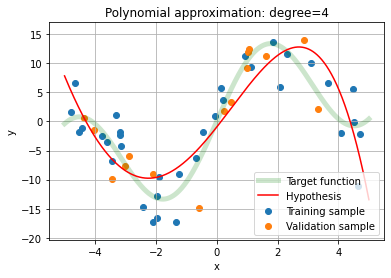

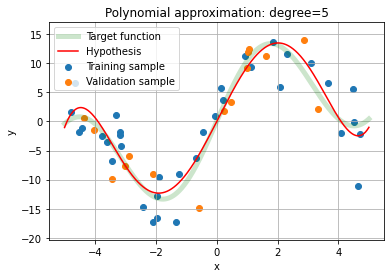

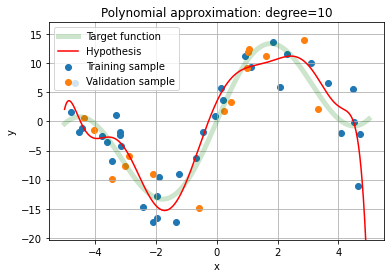

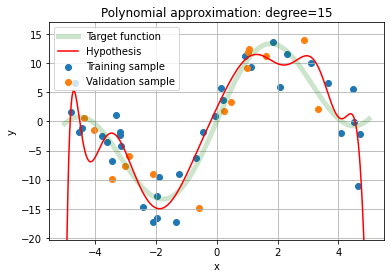

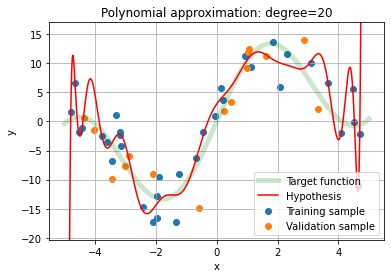

In [46]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

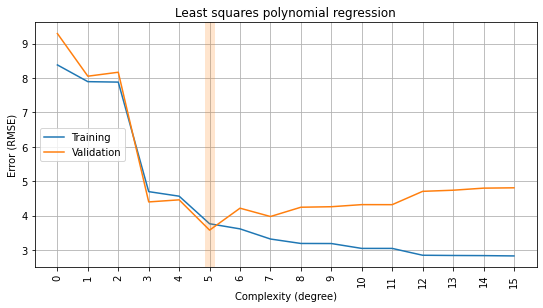

In [47]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [48]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

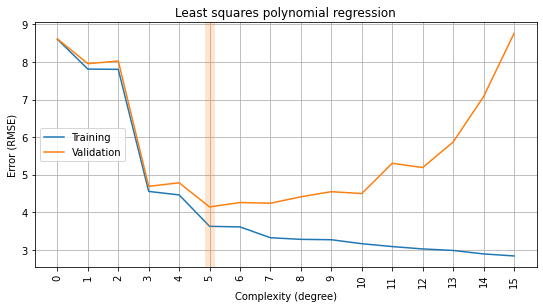

In [49]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [50]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

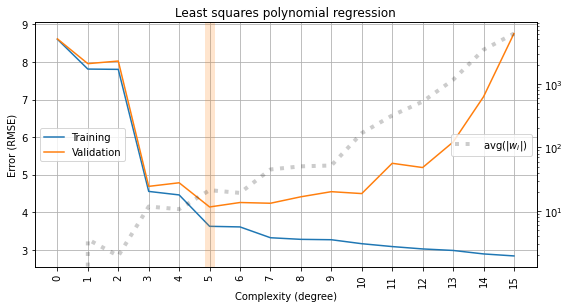

In [51]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

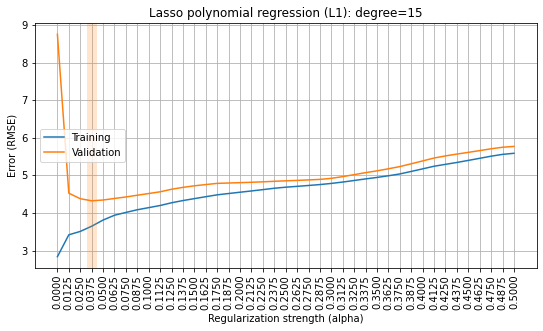

In [52]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

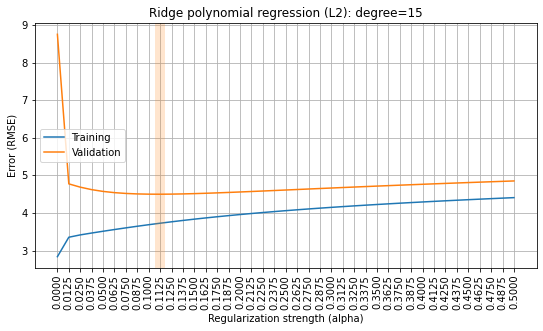

In [53]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [54]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

Из-за ограничений в вычислительной мощности компьютера возьмем не все параметры для генерации полиномов. Для этого рассчитаем зависимость параметров от целевой переменной и выберем наиболее коррелируемые.

In [55]:
data_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
data_diabetes['target'] = data['target']
data_diabetes.corr()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
age,1.000000,0.173737,0.185085,0.335427,0.260061,0.219243,-0.075181,0.203841,0.270777,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241013,0.035277,0.142637,-0.379090,0.332115,0.149918,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395415,0.249777,0.261170,-0.366811,0.413807,0.446159,0.388680,0.586450
bp,0.335427,0.241013,0.395415,1.000000,0.242470,0.185558,-0.178761,0.257653,0.393478,0.390429,0.441484
s1,0.260061,0.035277,0.249777,0.242470,1.000000,0.896663,0.051519,0.542207,0.515501,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185558,0.896663,1.000000,-0.196455,0.659817,0.318353,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178761,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257653,0.542207,0.659817,-0.738493,1.000000,0.617857,0.417212,0.430453
s5,0.270777,0.149918,0.446159,0.393478,0.515501,0.318353,-0.398577,0.617857,1.000000,0.464670,0.565883
s6,0.301731,0.208133,0.388680,0.390429,0.325717,0.290600,-0.273697,0.417212,0.464670,1.000000,0.382483


Исходя из матрицы сильно коррелируемых пар в данном датасете нету. Занесем признаки в список в зависимости от степени корреляции к целевому признаку.

In [67]:
colir = data_diabetes.corr().abs().unstack().sort_values(kind="quicksort",ascending = False)
col_new=colir['target'].index[1:8].to_list() # занесли в список название параметров.
col_new

['bmi', 's5', 'bp', 's4', 's3', 's6', 's1']

In [57]:
from sklearn.compose import ColumnTransformer

In [58]:
X_diabetes

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930


Мы видим, что наши признаки находятся в одной шкале, поэтому нет смысла использовать стандартизацию. Поэтому в функции make_model_new уберем из Pipeline стандартизацию.

In [68]:
def make_model_new(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    columnTransformer = ColumnTransformer([('PolynomialFeatures', PolynomialFeatures(degree, include_bias=(degree == 0)), ['bmi', 's5', 'bp', 's4', 's3', 's6', 's1'])], remainder='passthrough')
    
    return Pipeline([
        ('PolynomialFeatures', columnTransformer),
        ('reg', regressor)])

display(make_model_new(2))
display(make_model_new(2, penalty='L1', alpha=0.1))
display(make_model_new(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('PolynomialFeatures',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('PolynomialFeatures',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['bmi', 's5', 'bp', 's4',
                                                   's3', 's6', 's1'])])),
                ('reg', LinearRegression())])

Pipeline(steps=[('PolynomialFeatures',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('PolynomialFeatures',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['bmi', 's5', 'bp', 's4',
                                                   's3', 's6', 's1'])])),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('PolynomialFeatures',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('PolynomialFeatures',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['bmi', 's5', 'bp', 's4',
                                                   's3', 's6', 's1'])])),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

In [69]:
def plot_fitting_graph_new(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()

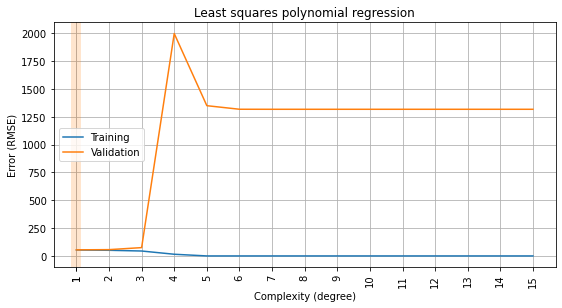

In [70]:
rmse_train, rmse_valid = [], []
DEGREES_2 = np.linspace(1, 15, 1 + 15, dtype=int)
for degree in DEGREES_2:
    results = cross_validate(make_model_new(degree), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph_new(DEGREES_2, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')


Из графика видно, что для построения модели лучше подходит полином первой степени.  Так как на графике сложно посмотреть, как изменяется ошибка от начальных степеней полинома, построим график от 1 до 3 степени. Проверим точно ли первая степень полинома является оптимальной. 


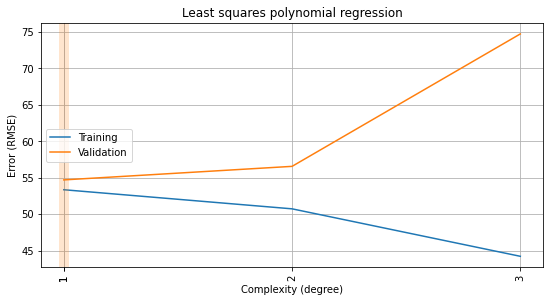

In [71]:
rmse_train, rmse_valid = [], []
DEGREES_2 = np.linspace(1, 3, 1 + 3, dtype=int)
for degree in DEGREES_2:
    results = cross_validate(make_model_new(degree), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph_new(DEGREES_2, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

На основании данного графика мы точно убедились, что первая степень полинома является оптимальной так как при 2 степени уже происходит увеличение ошибки RMSE для validation и увеличивается расхождение между training и validation. 

На основании графиков мы можем сказать, что наименьшая ошибка для validation при первой степени полинома. При 2 степени мы наблюдаем незначительны рост ошибки, поэтому мы можем сказать, что в нашей модели отсутствует недообучение. От 3 степени и выше происходит существенный прирост ошибки validation, а также ошибка при training начинает стремится к 0. Это говорит о том, что наш алгоритм переобучился на тренировочных данных.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

В данном разделе мы не будем использовать метод cross_validate так как не хватает мощности для расчёта. Для этого разделим наши данные на тренировочные и тестовые.

In [73]:
X_train_data, X_valid_data, y_train_data, y_valid_data = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

In [76]:
print('Размер данных для обучения', X_train_data.shape)
print('Размер данных для тестирования ', X_valid_data.shape)

Размер данных для обучения (309, 10)
Размер данных для тестирования  (133, 10)


Мы видим, что наши данные успешно разделились на обучающие и тестовые в соотношении 70% к 30%.

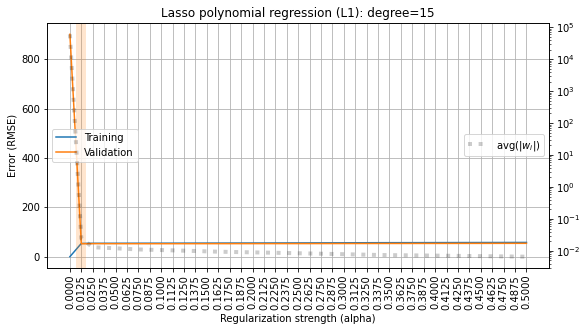

In [81]:
rmse_train, rmse_valid, avg_coef_l1 = [], [], []
for alpha in ALPHAS:    
    model_l1 = make_model_new(degree=15, penalty='L1', alpha=alpha).fit(X_train_data, y_train_data)
    
    rmse_train.append(rmse(model_l1.predict(X_train_data), y_train_data))
    rmse_valid.append(rmse(model_l1.predict(X_valid_data), y_valid_data))
    avg_coef_l1.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model_l1['reg'].coef_))
            ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_l1, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')


На графике видно, что при альфа равном 0 достигается большое значение ошибки RMSE, из-за чего наш график имеет по оси y большое деление. Для наиболее лучшей наглядности воздействия на модель L1 регуляризации уберем 0 альфу из графика

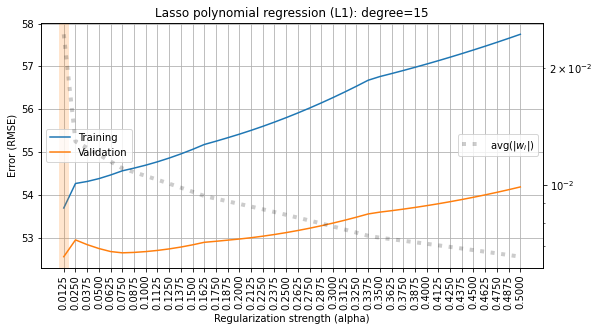

In [83]:
rmse_train, rmse_valid, avg_coef_l1_new = [], [], []
ALPHAS_new = np.linspace(0.0125, 0.5, 1 + 39)
for alpha in ALPHAS_new:    
    model_l1 = make_model_new(degree=15, penalty='L1', alpha=alpha).fit(X_train_data, y_train_data)
    
    rmse_train.append(rmse(model_l1.predict(X_train_data), y_train_data))
    rmse_valid.append(rmse(model_l1.predict(X_valid_data), y_valid_data))
    avg_coef_l1_new.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model_l1['reg'].coef_))
            ]))
    
plot_fitting_graph(ALPHAS_new, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_l1_new, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')

Мы видим, что наименьшая ошибка на тестовом наборе приходится при значении альфа коэффициента равным 0,0125. Далее при увеличении альфы мы можем наблюдать и рост ошибки. Рассмотри как L1 регуляризация влияет на коэффициенты весов нашей модели.

In [79]:
def plot_weights(x, avg_weights, xlabel, ylabel, title='Fitting graph'):
    plt.figure(figsize=(16, 4))
    plt.plot(x, avg_weights, label='weights')   
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.yscale('log')
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='best') 
    plt.show()

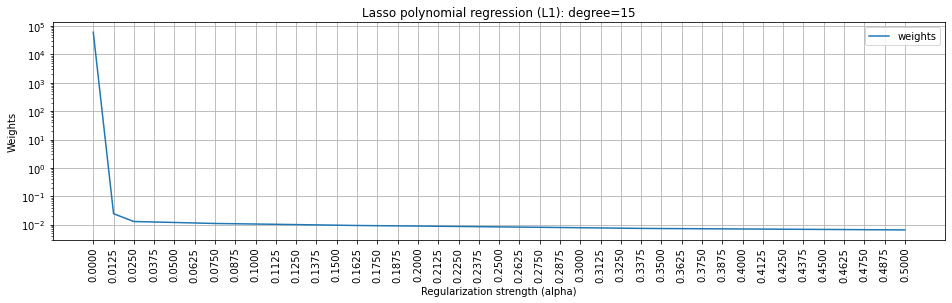

In [82]:
plot_weights(ALPHAS, avg_coef_l1,
                   xlabel='Regularization strength (alpha)', ylabel='Weights',
                   title='Lasso polynomial regression (L1): degree=15')

Исходя из графика зависимости весов от коэффициента альфа, мы можем сказать, что увеличение альфа коэффициента, при L1 регуляризации, существенно влияет на уменьшение значений весов нашей модели. 


#### L2

Сделаем те же самые действия только для L2 регуляризации. 

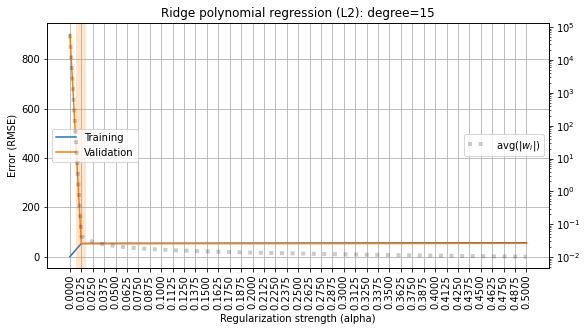

In [84]:
rmse_train, rmse_valid, avg_coef_l2 = [], [], []
for alpha in ALPHAS:    
    model_l2 = make_model_new(degree=15, penalty='L2', alpha=alpha).fit(X_train_data, y_train_data)
    
    rmse_train.append(rmse(model_l2.predict(X_train_data), y_train_data))
    rmse_valid.append(rmse(model_l2.predict(X_valid_data), y_valid_data))
    avg_coef_l2.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model_l2['reg'].coef_))
            ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_l2, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

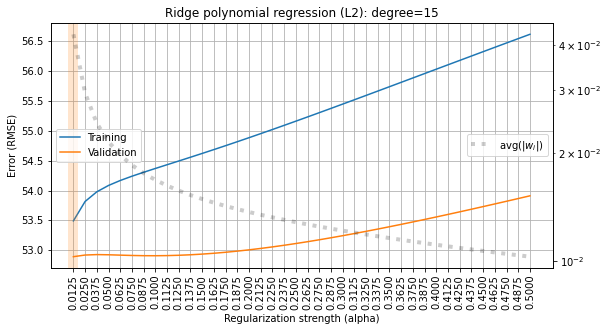

In [85]:
rmse_train, rmse_valid, avg_coef_l2_new = [], [], []
for alpha in ALPHAS_new:    
    model_l2 = make_model_new(degree=15, penalty='L2', alpha=alpha).fit(X_train_data, y_train_data)
    
    rmse_train.append(rmse(model_l2.predict(X_train_data), y_train_data))
    rmse_valid.append(rmse(model_l2.predict(X_valid_data), y_valid_data))
    avg_coef_l2_new.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model_l2['reg'].coef_))
            ]))
    
plot_fitting_graph(ALPHAS_new, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_l2_new, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

Мы видим, что наименьшая ошибка на тестовом наборе приходится при значении альфа коэффициента равным 0,0125, как и при L1 регуляризации.

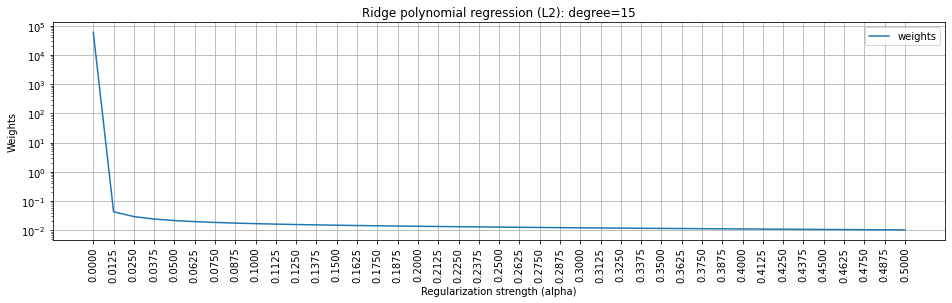

In [86]:
plot_weights(ALPHAS, avg_coef_l2,
                   xlabel='Regularization strength (alpha)', ylabel='Weights',
                   title='Ridge polynomial regression (L2): degree=15')

Исходя из графика видно, что увеличение альфа коэффициента, при L2 регуляризации, существенно влияет на уменьшение значений весов нашей модели, как и при L1 регуляризации.

#### Summary

Исходя из графиков мы можем сказать, что методы регуляризации приводят к ограничиванию весов. При больших значениях коэффициента альфа достигается низкое значение коэффициентов весов. Разница между методом “Регрессия Лассо” и методом “Регрессия  хребта” в том, что “Регрессия Лассо” уменьшает коэффициенты менее важного параметра до нуля, тем самым полностью удаляя его при построении обучающей модели.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

Посчитаем значение весов при различных коэффициентах альфа для L1 регуляризации.

In [169]:
coef_L1 = []
for alpha in ALPHAS:    
    model_l1 = make_model_new(degree=15, penalty='L1', alpha=alpha).fit(X_train_data, y_train_data)
    if alpha == 0:
        coef_L1.append((alpha,model_l1['reg'].coef_[0]))
    else:
        coef_L1.append((alpha,model_l1['reg'].coef_))
    

Выведем количество не нулевых признаков при различных значениях коэффициента альфа.

In [212]:
percent_zero = []
for coef in coef_L1:
    percent_zero.append((coef[0], 100 - (np.count_nonzero(coef[1])*100)/len(coef[1]))) # занесем в отдельный список процент нулевых 
    #признаков от общего числа в зависимости от альфы
    print("При значении Alpha:'{:.3f}'".format(coef[0]), "- количество не нулевых признаков равно {0}".format(np.count_nonzero(coef[1])))
    

При значении Alpha:'0.000' - количество не нулевых признаков равно 170546
При значении Alpha:'0.013' - количество не нулевых признаков равно 13
При значении Alpha:'0.025' - количество не нулевых признаков равно 9
При значении Alpha:'0.038' - количество не нулевых признаков равно 9
При значении Alpha:'0.050' - количество не нулевых признаков равно 9
При значении Alpha:'0.062' - количество не нулевых признаков равно 9
При значении Alpha:'0.075' - количество не нулевых признаков равно 8
При значении Alpha:'0.088' - количество не нулевых признаков равно 7
При значении Alpha:'0.100' - количество не нулевых признаков равно 7
При значении Alpha:'0.113' - количество не нулевых признаков равно 7
При значении Alpha:'0.125' - количество не нулевых признаков равно 7
При значении Alpha:'0.138' - количество не нулевых признаков равно 7
При значении Alpha:'0.150' - количество не нулевых признаков равно 7
При значении Alpha:'0.163' - количество не нулевых признаков равно 7
При значении Alpha:'0.175' -

На основании данных можно сказать, что при L1 регуляризации с увеличением коэффициента альфа количество нулевых признаков увеличивается. В нашем случаи при альфа равном 0.5 осталось только 4 признака из 170546. 

Построим график зависимости коэффициента альфа от процента нулевых признаков.

In [213]:
data_coef = pd.DataFrame(percent_zero, columns=['alpha','percent_zero'])

In [214]:
def percent_zero(alpha, percent_zero, xlabel, ylabel, title='Fitting graph'):
    plt.figure(figsize=(16, 4))
    plt.plot(alpha, percent_zero, label='weights')   
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.yscale('log')
    plt.xticks(alpha, rotation='vertical')
    plt.legend(loc='best') 
    plt.show()

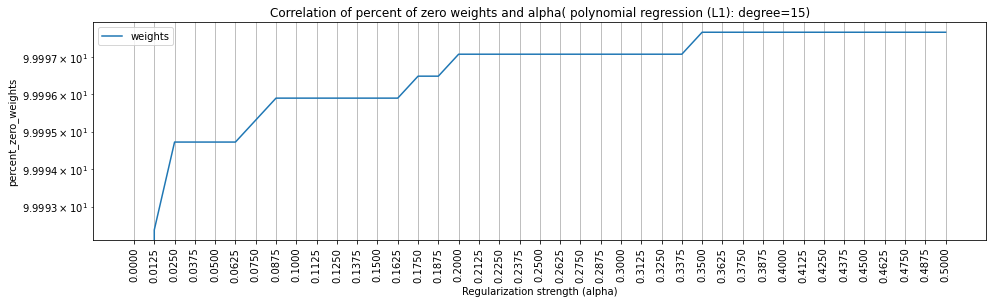

In [215]:
percent_zero(data_coef['alpha'], data_coef['percent_zero'],
                   xlabel='Regularization strength (alpha)', ylabel='percent_zero_weights',
                   title='Correlation of percent of zero weights and alpha( polynomial regression (L1): degree=15)')

Тоже самое мы наблюдаем и на графике. Уже при коэффициенте альфа 0.025 процент нулевых признаков составляет более 99%.

#### L2

Сделаем тоже самое и для L2 регуляризации.

In [224]:
coef_L2 = []
for alpha in ALPHAS:    
    model_l2 = make_model_new(degree=15, penalty='L2', alpha=alpha).fit(X_train_data, y_train_data)
    coef_L2.append((alpha,model_l2['reg'].coef_[0]))

In [255]:
for coef in coef_L2:
    print("При значении Alpha:'{:.3f}'".format(coef[0]), "- количество нулевых признаков равно {0}".format(len(coef[1])-np.count_nonzero(coef[1])))

При значении Alpha:'0.000' - количество нулевых признаков равно 0
При значении Alpha:'0.013' - количество нулевых признаков равно 0
При значении Alpha:'0.025' - количество нулевых признаков равно 0
При значении Alpha:'0.038' - количество нулевых признаков равно 0
При значении Alpha:'0.050' - количество нулевых признаков равно 0
При значении Alpha:'0.062' - количество нулевых признаков равно 0
При значении Alpha:'0.075' - количество нулевых признаков равно 0
При значении Alpha:'0.088' - количество нулевых признаков равно 0
При значении Alpha:'0.100' - количество нулевых признаков равно 0
При значении Alpha:'0.113' - количество нулевых признаков равно 0
При значении Alpha:'0.125' - количество нулевых признаков равно 0
При значении Alpha:'0.138' - количество нулевых признаков равно 0
При значении Alpha:'0.150' - количество нулевых признаков равно 0
При значении Alpha:'0.163' - количество нулевых признаков равно 0
При значении Alpha:'0.175' - количество нулевых признаков равно 0
При значен

Мы видим, что при L2 регуляризации вне зависимости от коэффициента альфа не один параметр не стал нулевым. 

Для интереса посмотрим минимальное значение веса признака при коэффициенте альфа равном 0.5

In [260]:
data_l2 = pd.DataFrame(coef_L2, columns=['alpha','weights'])
print('Минимальное значение веса признака:', min(np.abs(data_l2['weights'][data_l2['alpha'] == 0.5].to_list()[0])))


Минимальное значение веса признака: 1.3596930275726386e-19


Мы видим, что самое минимальное значение веса не равно нулю но стримится к нему. 

#### Summary

При L1 регуляризации мы наблюдали, что при увеличении коэффициента альфа уменьшаются коэффициенты менее важных признаков до нуля, тем самым полностью удаляя их при построении обучающей модели. В нашем случае из 170546 признаков осталось только 4. При L2 регуляризации мы наблюдаем другую картину, что при увеличении коэффициента альфа веса только стремятся к нулю. В нашем случае L2 регуляризация используют все признаки. 

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [261]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


Создадим две функции. Одна функция будем включать метод StandardScaler, а вторая нет. 

In [264]:
def make_model_Standard(alpha=0, penalty=None):
    # lasso regression",
    if penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    return Pipeline([
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])
display(make_model_Standard(penalty='L1', alpha=0.1))
display(make_model_Standard(penalty='L2', alpha=0.1))

Pipeline(steps=[('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

In [265]:
def make_model_Standard_not(alpha=0, penalty=None):
    # lasso regression",
    if penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    return Pipeline([
        ('reg', regressor)
    ])
display(make_model_Standard_not(penalty='L1', alpha=0.1))
display(make_model_Standard_not(penalty='L2', alpha=0.1))

Pipeline(steps=[('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

#### L1


Для начала построим модель без использования масштабирования  входных данных с использованием L1 регуляризации.


In [344]:
print('Размер данных:', X_hw.shape)

Размер данных: (50, 3)


Так как размер данных небольшой используем кросс-валидации с разбиение не на 5 частей, а на 2.

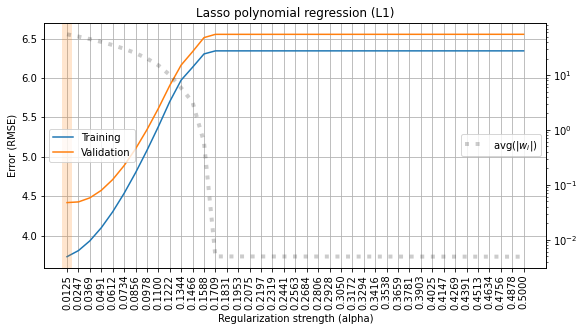

In [345]:
rmse_train, rmse_valid, avg_coef = [], [], []
ALPHAS = np.linspace(0.0125, 0.5, 1 + 40)
for alpha in ALPHAS:    
    results = cross_validate(make_model_Standard_not(penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=2,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
 
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)', 
                   title='Lasso polynomial regression (L1)')


Мы видим, что при L1 регуляризации без использования метода StandardScaler наилучшая модель получатся при коэффициенте альфа равным 0.0125. Рассмотрим значение ошибки RMSE данной модели.

In [346]:
print('Наименьшее значение ошибки RMSE для тестового набора :', min(rmse_valid))

Наименьшее значение ошибки RMSE для тестового набора : 4.42003796801089


Посмотрим, что измениться при использовании метода StandardScaler.

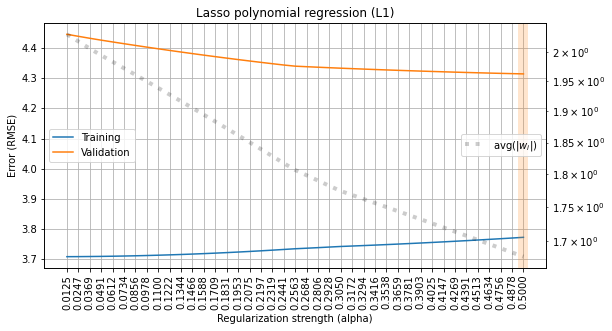

In [347]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_Standard(penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=2,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
 
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)', 
                   title='Lasso polynomial regression (L1)')

При использовании метода StandardScaler наилучшая модель получатся при коэффициенте альфа равным 0.5. При этом мы видим, что значение ошибок RMSE и весов меньше, чем при построении модели без метода StandardScaler. Уменьшение весов говорит о том что мы избавляемся от лишнего шума.

In [348]:
print('наименьшее значение ошибки RMSE для тестового набора:', min(rmse_valid))

наименьшее значение ошибки RMSE для тестового набора: 4.315058182912594


#### L2

Построим модель без использования масштабирования входных данных с использованием L2 регуляризации

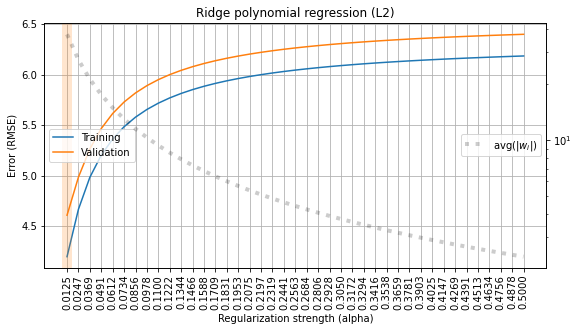

In [350]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_Standard_not(penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=2,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
 
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)', 
                   title='Ridge polynomial regression (L2)')

Мы видим, что при L2 регуляризации без использования метода StandardScaler наилучшая модель получатся при коэффициенте альфа равным 0.0125, как и при L1 регуляризации. Рассмотрим значение ошибки RMSE данной модели.

In [351]:
print('наименьшее значение ошибки RMSE для тестового набора:', min(rmse_valid))

наименьшее значение ошибки RMSE для тестового набора: 4.609953472335068


Посмотрим, что измениться при использовании метода StandardScaler.

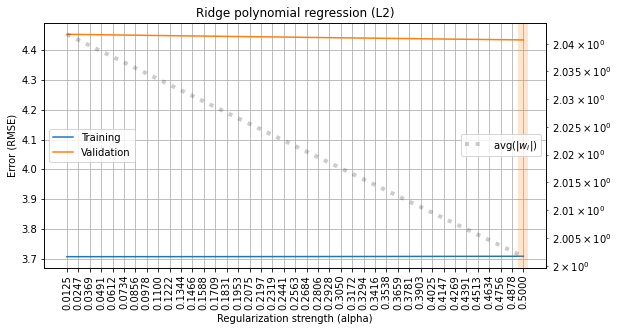

In [352]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_Standard(penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=2,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
 
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)', 
                   title='Ridge polynomial regression (L2)')

In [353]:
print('наименьшее значение ошибки RMSE для тестового набора:', min(rmse_valid))

наименьшее значение ошибки RMSE для тестового набора: 4.434312159307595


При использовании метода StandardScaler наилучшая модель получатся при коэффициенте альфа равным 0.5. При этом мы видим, что когда мы не использовали данный метод при L1 и L2 регуляризации значение ошибок RMSE при увеличении коэффициента альфа существенно увеличивалось, а при его использовании мы наблюдаем другую картину, значение ошибок незначительно уменьшилось.  

 

#### Summary



На основании сделанного анализа мы можем сказать, что масштабирование данных улучшило результаты модели. Значение ошибки RMSE как для обучающего набора, так и для тестового уменьшилось при использовании стандартизации. Значение коэффициентов весов так же уменьшились, это означает, что масштабирование избавляется от наличия больших весов.